In [32]:
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import ETFs as etfs

In [21]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
# display(data)

In [22]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)

## Test data correctness

In [23]:
test_df = pd.DataFrame({'Close_yesterday': data['SPY'].shift(1),'Close Tody':data['SPY'],'Target': binary_targets['SPY']})
display(test_df)

,Close_yesterday,Close Tody,Target
Date,,,
2012-01-03,NaN,100.450684,0
2012-01-04,100.450684,100.608261,1
2012-01-05,100.608261,100.876129,1
2012-01-06,100.876129,100.616127,0
2012-01-09,100.616127,100.860359,1
...,...,...,...
2025-03-24,563.979980,574.080017,1
2025-03-25,574.080017,575.460022,1
2025-03-26,575.460022,568.590027,0


In [24]:
dataset_size = len(data)
train_size = int(dataset_size * 0.8)
test_size = int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

binary_targets_train = binary_targets.iloc[:train_size]
binary_targets_val = binary_targets.iloc[train_size:train_size + val_size]
binary_targets_test = binary_targets.iloc[train_size + val_size:]


In [25]:
def create_X_y_rolling(df, target_label, window_size):
    X, y, labels, first_values = [], [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value  
        X.append(normalized_window.values)
        
        y_target = df.iloc[i+window_size] / first_value  
        y.append(y_target.values)
        
        l = target_label.iloc[i+window_size]
        labels.append(l)
        
        first_values.append(first_value.values) 
        
    X = np.array(X)
    y = np.array(y)
    first_values = np.array(first_values)
    labels = np.array(labels)
    return X, y, first_values, labels

window_size = 30


X_train, y_train, first_values_train, labels_train = create_X_y_rolling(train_data, binary_targets_train, window_size)
X_val, y_val, first_values_val, labels_val = create_X_y_rolling(val_data, binary_targets_val, window_size)
X_test, y_test, first_values_test, labels_test = create_X_y_rolling(test_data, binary_targets_test, window_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, labels_train.shape, labels_val.shape, labels_test.shape


((2696, 30, 33),
 (2696, 33),
 (312, 30, 33),
 (312, 33),
 (310, 30, 33),
 (310, 33),
 (2696, 33),
 (312, 33),
 (310, 33))

In [26]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001)),
    Dropout(0.3), 

    LSTM(64, return_sequences=False),
    Dropout(0.4),  

    Dense(labels_train.shape[1], activation='sigmoid'),
])


model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0001),   
              metrics=['binary_accuracy',])

cp = ModelCheckpoint(filepath='model_binary/best_binary.keras', 
                     save_best_only=True, monitor='val_loss', 
                     mode='min')

es = EarlyStopping(
    monitor='val_binary_accuracy',        
    patience=10,                
    restore_best_weights=True 
)

history = model.fit(
    X_train, labels_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, labels_val),
    callbacks=[cp, es],
)
# model.summary()




c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 29s 201ms/step - binary_accuracy: 0.5361 - loss: 0.7486 - val_binary_accuracy: 0.5049 - val_loss: 0.7619
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - binary_accuracy: 0.5471 - loss: 0.7326 - val_binary_accuracy: 0.5035 - val_loss: 0.7608
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - binary_accuracy: 0.5536 - loss: 0.7240 - val_binary_accuracy: 0.5034 - val_loss: 0.7606
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - binary_accuracy: 0.5537 - loss: 0.7170 - val_binary_accuracy: 0.5052 - val_loss: 0.7573
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - binary_accuracy: 0.5519 - loss: 0.7130 - val_binary_accuracy: 0.5051 - val_loss: 0.7547
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - binary_accuracy: 0.5534 - loss: 0.7093 - val_binary_accuracy: 0.5049 - val_loss: 0.7542
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - binary_accuracy: 0.5547 - loss: 0.7052 - val_binary_accuracy: 0.5022 - val_loss: 0.752

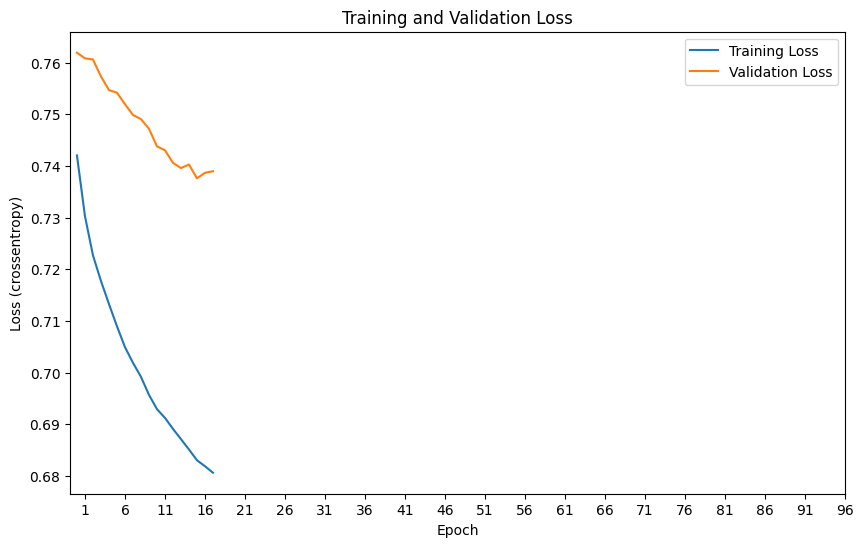

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (crossentropy)')
plt.legend()
xticks = np.arange(1, 100, 5)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model = load_model('model_binary/best_binary.keras')
index_series = data.index[-len(y_test):]

y_pred = model.predict(X_test)
# display(y_pred)

y_pred_classes = (y_pred > 0.5).astype(int)

Predict_result_df = pd.DataFrame(y_pred_classes, index=index_series, columns=data.columns)

actual_flat = y_pred_classes.flatten()
predicted_flat = labels_test.flatten()
accuracy = accuracy_score(actual_flat, predicted_flat)
precision = precision_score(actual_flat, predicted_flat)
recall = recall_score(actual_flat, predicted_flat)
f1 = f1_score(actual_flat, predicted_flat)
roc_auc = roc_auc_score(actual_flat, predicted_flat)  
cm = confusion_matrix(actual_flat, predicted_flat)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4}")
print(f"Confusion Matrix:\n{cm}")
f1_scor = f1_score(y_pred_classes.flatten(), labels_test.flatten())
# display(Predict_result_df)
print("F1:", )
print("Precision:", precision_score(y_pred_classes.flatten(), labels_test.flatten()))
print("Recall:", recall_score(y_pred_classes.flatten(), labels_test.flatten()))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Accuracy: 0.4965
Precision: 0.5155
Recall: 0.5084
F1 Score: 0.5119
AUC-ROC: 0.496
Confusion Matrix:
[[2378 2539]
 [2612 2701]]
F1:
Precision: 0.5154580152671756
Recall: 0.5083756822887258


In [29]:
from sklearn.metrics import accuracy_score

actual_flat = labels_test.flatten()
predicted_flat = Predict_result_df.to_numpy().flatten()
accuracy = accuracy_score(actual_flat, predicted_flat)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.4965
